In [11]:
import scanpy as sc
import surgeon
sc.settings.set_figure_params(dpi=200, frameon=False)

In [12]:
condition_key = "batch"
cell_type_key = 'cell.type'
target_condition = "10X_v3"

# Loading mouse lung atlas datasets and data preparation

In [13]:
adata = sc.read("./data/lung_atlas/lung_atlas.h5ad")

#### normalizatiom and  Extracting HVGs 

In [14]:
sc.pp.normalize_per_cell(adata)

In [15]:
sc.pp.log1p(adata)

In [16]:
sc.pp.highly_variable_genes(adata,n_top_genes=1000)

In [17]:
adata = adata[:,adata.var["highly_variable"]]

In [18]:
adata

View of AnnData object with n_obs × n_vars = 36373 × 1000 
    obs: 'batch', 'cell.type', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Number of cells in each batch

In [19]:
adata.obs[condition_key].value_counts()

0    26013
1    10360
Name: batch, dtype: int64

## visualization  of the original data

In [20]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


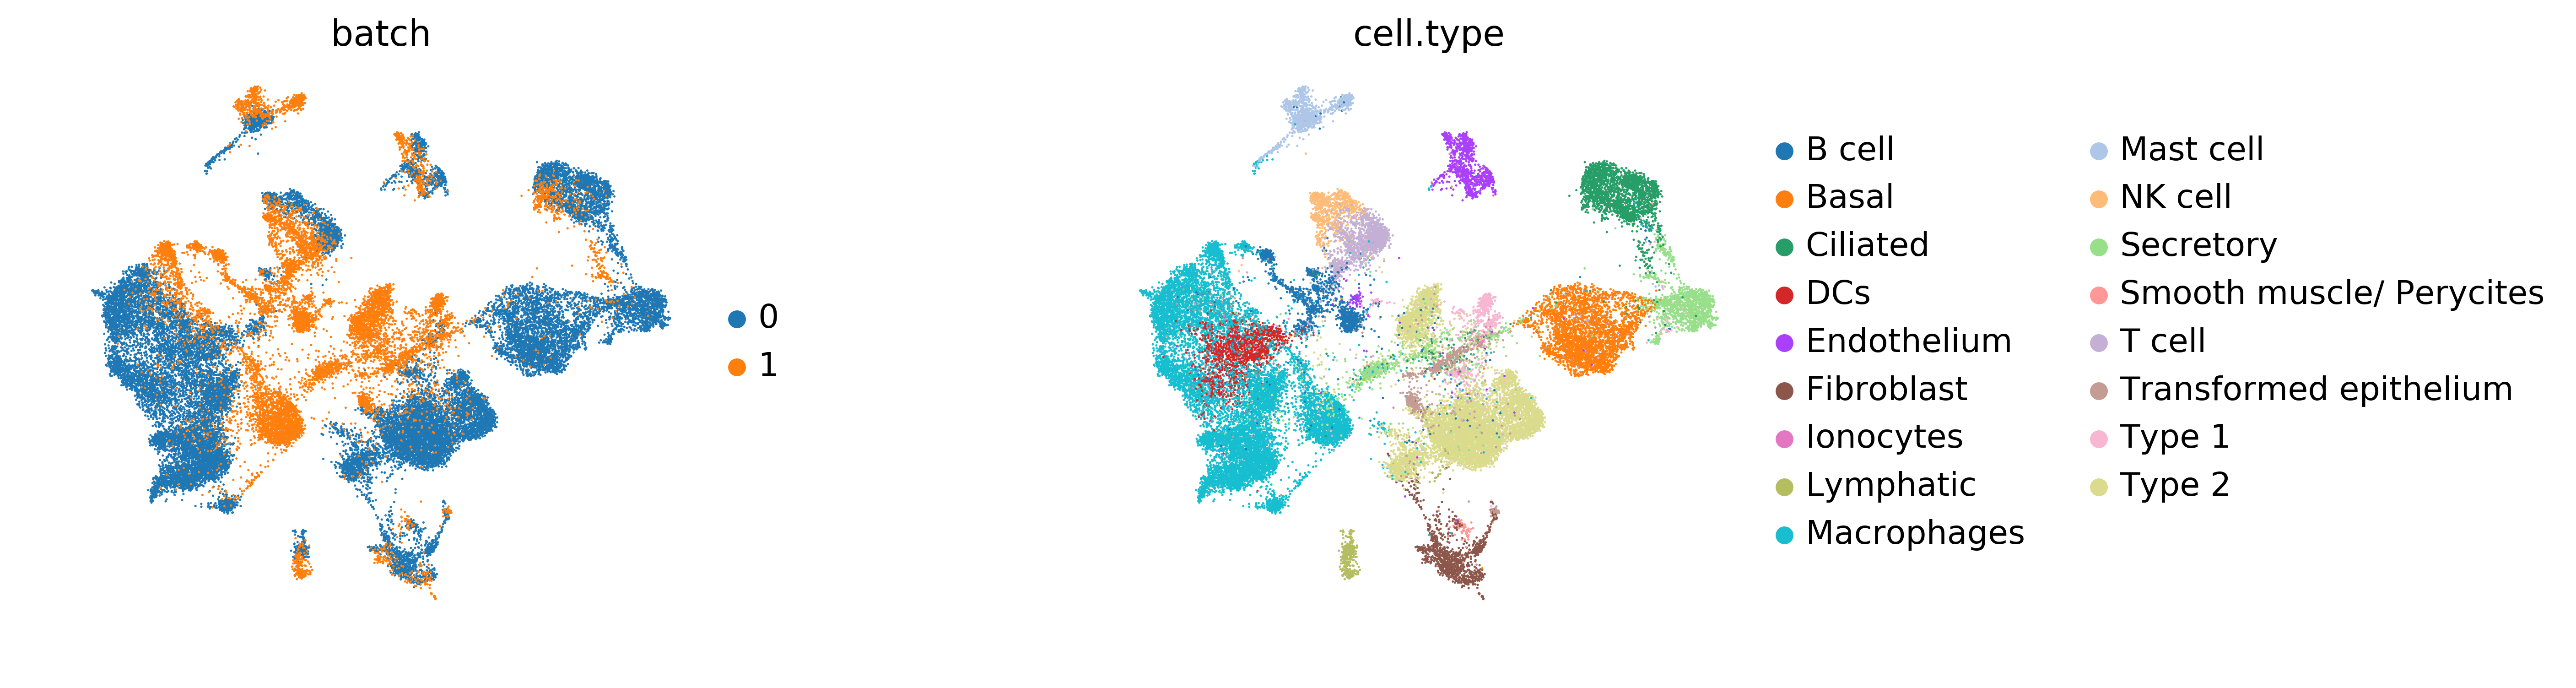

In [21]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.5)

## Now we leave out one study  (10X_v3) for training the newtork

In [22]:
adata_for_training = adata
adata_for_training

AnnData object with n_obs × n_vars = 36373 × 1000 
    obs: 'batch', 'cell.type', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'batch_colors', 'cell.type_colors'
    obsm: 'X_pca', 'X_umap'

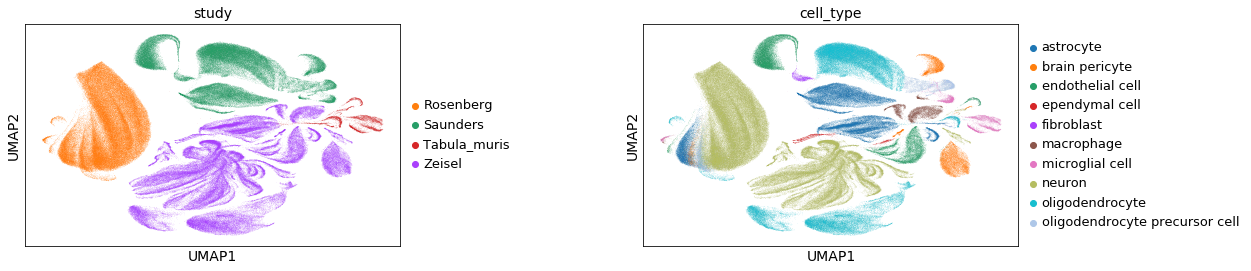

In [23]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [42]:
adata_out_of_sample = adata[adata.obs[condition_key] == target_condition]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 11741 × 2000 
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'cluster', 'louvain', 'louvain_R', 'mt_frac', 'n_counts', 'n_genes', 'sample', 'sample_type', 'study', 'subtissue'
    var: 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_counts-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'study_colors', 'batch_colors', 'sample_colors', 'cell_type_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Train/Test Split

In [23]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [24]:
train_adata.shape, valid_adata.shape

((30917, 1000), (5456, 1000))

In [25]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [27]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=100.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/lung/",
                             dropout_rate=0.2,
                             output_activation='relu')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 1002)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          513024      concatenate_3[0][0]              
__________

## We assign each study to a numerical label 

In [28]:
train_adata.obs[condition_key].value_counts()

0    22092
1     8825
Name: batch, dtype: int64

In [29]:
condition_encoder = {'0': 0, '1': 1}

## Training the network

In [30]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=300,
              batch_size=128, 
              early_stop_limit=20,
              lr_reducer=15, 
              save=True, 
              verbose=2)

Train on 30917 samples, validate on 5456 samples
Epoch 1/300
 - 3s - loss: 23.1898 - kl_recon_loss: 23.1898 - val_loss: 17.7008 - val_kl_recon_loss: 17.7008
Epoch 2/300
 - 1s - loss: 18.0892 - kl_recon_loss: 18.0892 - val_loss: 16.4603 - val_kl_recon_loss: 16.4603
Epoch 3/300
 - 1s - loss: 17.1717 - kl_recon_loss: 17.1717 - val_loss: 15.7993 - val_kl_recon_loss: 15.7993
Epoch 4/300
 - 1s - loss: 16.6981 - kl_recon_loss: 16.6981 - val_loss: 15.4066 - val_kl_recon_loss: 15.4066
Epoch 5/300
 - 1s - loss: 16.4360 - kl_recon_loss: 16.4360 - val_loss: 15.3058 - val_kl_recon_loss: 15.3058
Epoch 6/300
 - 1s - loss: 16.2565 - kl_recon_loss: 16.2565 - val_loss: 15.0975 - val_kl_recon_loss: 15.0975
Epoch 7/300
 - 1s - loss: 16.0933 - kl_recon_loss: 16.0933 - val_loss: 15.0499 - val_kl_recon_loss: 15.0499
Epoch 8/300
 - 1s - loss: 15.9847 - kl_recon_loss: 15.9847 - val_loss: 14.9885 - val_kl_recon_loss: 14.9885
Epoch 9/300
 - 1s - loss: 15.8474 - kl_recon_loss: 15.8474 - val_loss: 14.8442 - val_kl

Epoch 76/300
 - 1s - loss: 14.3501 - kl_recon_loss: 14.3501 - val_loss: 13.7042 - val_kl_recon_loss: 13.7042
Epoch 77/300
 - 1s - loss: 14.3360 - kl_recon_loss: 14.3360 - val_loss: 13.7202 - val_kl_recon_loss: 13.7202
Epoch 78/300
 - 2s - loss: 14.3381 - kl_recon_loss: 14.3381 - val_loss: 13.6990 - val_kl_recon_loss: 13.6990
Epoch 79/300
 - 1s - loss: 14.3359 - kl_recon_loss: 14.3359 - val_loss: 13.7124 - val_kl_recon_loss: 13.7124
Epoch 80/300
 - 2s - loss: 14.3267 - kl_recon_loss: 14.3267 - val_loss: 13.7165 - val_kl_recon_loss: 13.7165
Epoch 81/300
 - 2s - loss: 14.3261 - kl_recon_loss: 14.3261 - val_loss: 13.7073 - val_kl_recon_loss: 13.7073
Epoch 82/300
 - 1s - loss: 14.3145 - kl_recon_loss: 14.3145 - val_loss: 13.7014 - val_kl_recon_loss: 13.7014
Epoch 83/300
 - 2s - loss: 14.3210 - kl_recon_loss: 14.3210 - val_loss: 13.7041 - val_kl_recon_loss: 13.7041
Epoch 84/300
 - 1s - loss: 14.3194 - kl_recon_loss: 14.3194 - val_loss: 13.6981 - val_kl_recon_loss: 13.6981
Epoch 85/300
 - 2s 

Epoch 151/300
 - 1s - loss: 14.1949 - kl_recon_loss: 14.1949 - val_loss: 13.6430 - val_kl_recon_loss: 13.6430
Epoch 152/300
 - 1s - loss: 14.1937 - kl_recon_loss: 14.1937 - val_loss: 13.6482 - val_kl_recon_loss: 13.6482
Epoch 153/300
 - 1s - loss: 14.1917 - kl_recon_loss: 14.1917 - val_loss: 13.6216 - val_kl_recon_loss: 13.6216
Epoch 154/300
 - 1s - loss: 14.2013 - kl_recon_loss: 14.2013 - val_loss: 13.6391 - val_kl_recon_loss: 13.6391
Epoch 155/300
 - 1s - loss: 14.1961 - kl_recon_loss: 14.1961 - val_loss: 13.6558 - val_kl_recon_loss: 13.6558
Epoch 156/300
 - 2s - loss: 14.2038 - kl_recon_loss: 14.2038 - val_loss: 13.6412 - val_kl_recon_loss: 13.6412
Epoch 157/300
 - 2s - loss: 14.1919 - kl_recon_loss: 14.1919 - val_loss: 13.6368 - val_kl_recon_loss: 13.6368
Epoch 158/300
 - 2s - loss: 14.1834 - kl_recon_loss: 14.1834 - val_loss: 13.6293 - val_kl_recon_loss: 13.6293
Epoch 159/300
 - 1s - loss: 14.1762 - kl_recon_loss: 14.1762 - val_loss: 13.6340 - val_kl_recon_loss: 13.6340
Epoch 160/

Epoch 226/300
 - 1s - loss: 14.1327 - kl_recon_loss: 14.1327 - val_loss: 13.6320 - val_kl_recon_loss: 13.6320
Epoch 227/300
 - 1s - loss: 14.1245 - kl_recon_loss: 14.1245 - val_loss: 13.6105 - val_kl_recon_loss: 13.6105
Epoch 228/300
 - 1s - loss: 14.1338 - kl_recon_loss: 14.1338 - val_loss: 13.6049 - val_kl_recon_loss: 13.6049
Epoch 229/300
 - 1s - loss: 14.1313 - kl_recon_loss: 14.1313 - val_loss: 13.6094 - val_kl_recon_loss: 13.6094
Epoch 230/300
 - 1s - loss: 14.1447 - kl_recon_loss: 14.1447 - val_loss: 13.6174 - val_kl_recon_loss: 13.6174
Epoch 231/300
 - 2s - loss: 14.1328 - kl_recon_loss: 14.1328 - val_loss: 13.6028 - val_kl_recon_loss: 13.6028
Epoch 232/300
 - 2s - loss: 14.1328 - kl_recon_loss: 14.1328 - val_loss: 13.6232 - val_kl_recon_loss: 13.6232
Epoch 233/300
 - 1s - loss: 14.1349 - kl_recon_loss: 14.1349 - val_loss: 13.6181 - val_kl_recon_loss: 13.6181
Epoch 234/300
 - 2s - loss: 14.1326 - kl_recon_loss: 14.1326 - val_loss: 13.6057 - val_kl_recon_loss: 13.6057
Epoch 235/

In [31]:
network.condition_encoder

{'0': 0, '1': 1}

In [32]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [33]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 30917 × 10 
    obs: 'batch', 'cell.type', 'n_counts'

In [34]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

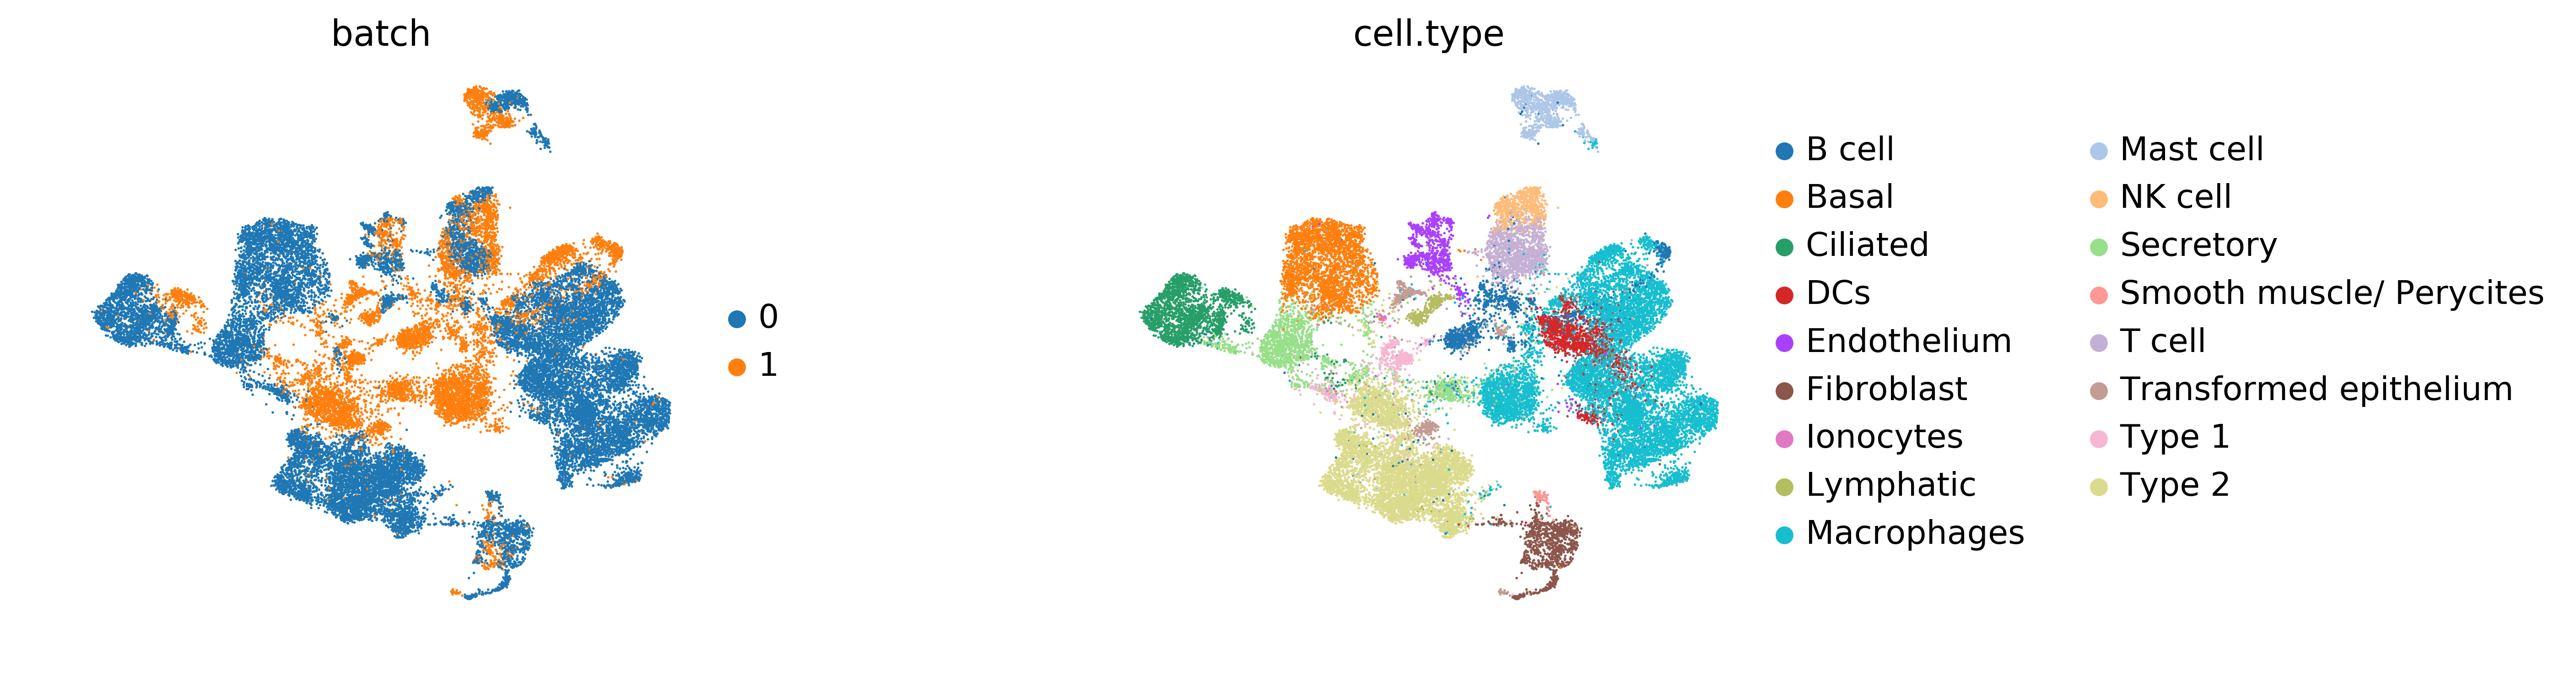

In [35]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [34]:
new_network = surgeon.operate(network, 
                              new_condition=target_condition,
                              init='Xavier', 
                              freeze=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2448)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2452)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1255424     concatenate_3[0][0]              
__________

In [35]:
new_network.condition_encoder

{'Baron': 0, 'Muraro': 1, 'Wang': 2, 'Segerstolpe': 3}

## Train with small new dataset containing out-of-sample condition

In [36]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [37]:
train_adata.shape, valid_adata.shape

((2858, 2448), (505, 2448))

In [38]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=100,
                  batch_size=128, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  save=True, 
                  verbose=2)

Train on 2858 samples, validate on 505 samples
Epoch 1/100
 - 1s - loss: 1083.7845 - kl_recon_loss: 1083.7845 - val_loss: 1083.3455 - val_kl_recon_loss: 1083.3455
Epoch 2/100
 - 0s - loss: 1070.3194 - kl_recon_loss: 1070.3194 - val_loss: 1077.3954 - val_kl_recon_loss: 1077.3954
Epoch 3/100
 - 0s - loss: 1064.6094 - kl_recon_loss: 1064.6094 - val_loss: 1073.1115 - val_kl_recon_loss: 1073.1115
Epoch 4/100
 - 0s - loss: 1062.3106 - kl_recon_loss: 1062.3106 - val_loss: 1070.8145 - val_kl_recon_loss: 1070.8145
Epoch 5/100
 - 0s - loss: 1059.5966 - kl_recon_loss: 1059.5966 - val_loss: 1069.2387 - val_kl_recon_loss: 1069.2387
Epoch 6/100
 - 0s - loss: 1057.6339 - kl_recon_loss: 1057.6339 - val_loss: 1068.4489 - val_kl_recon_loss: 1068.4489
Epoch 7/100
 - 0s - loss: 1056.8883 - kl_recon_loss: 1056.8883 - val_loss: 1067.2987 - val_kl_recon_loss: 1067.2987
Epoch 8/100
 - 0s - loss: 1055.7281 - kl_recon_loss: 1055.7281 - val_loss: 1066.7826 - val_kl_recon_loss: 1066.7826
Epoch 9/100
 - 0s - loss:

## Projecting all data in to the latent space of the model 

In [39]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [40]:
adata.obs[condition_key].value_counts()

Baron          8569
Segerstolpe    3363
Muraro         2126
Wang            635
Name: sample, dtype: int64

In [41]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 14693 × 10 
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'

In [42]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

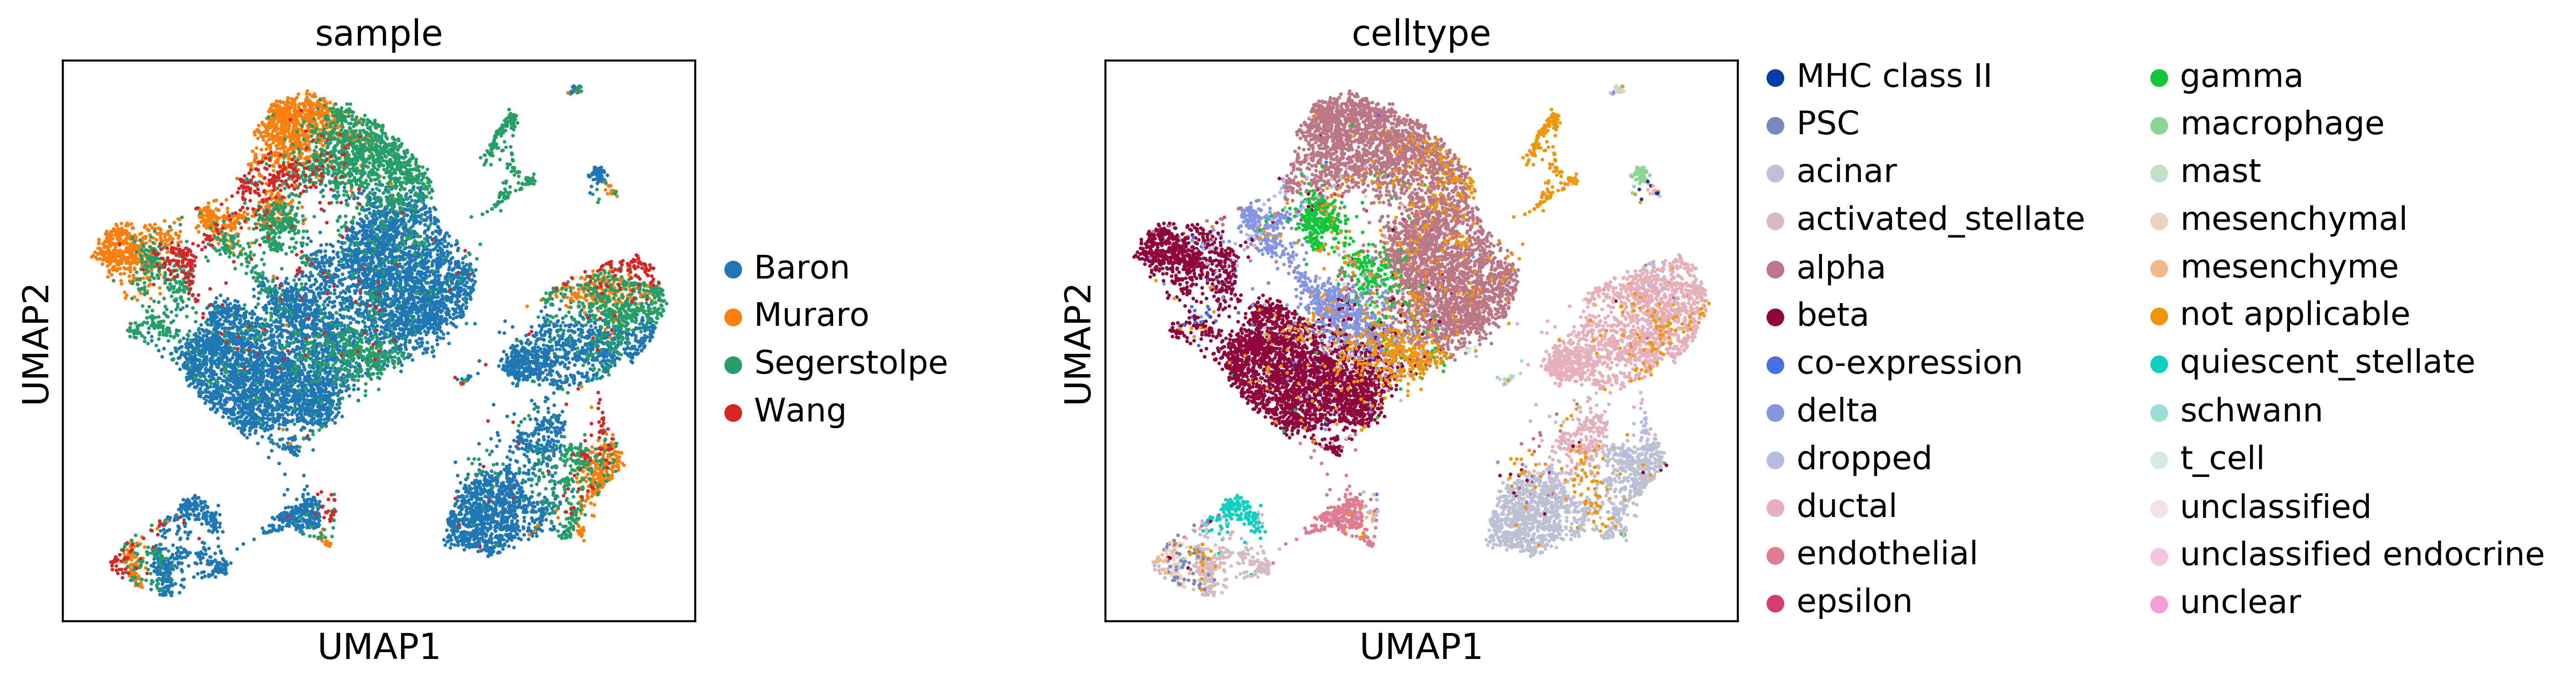

In [43]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)